In [80]:
import numpy as np
import rioxarray as rx
import rasterio
from rasterio.mask import mask
from pathlib import Path
import geopandas as gpd
import pprint
import re
import os
import glob
import xarray as xr
import matplotlib.pyplot as plt
import xarray
import pandas as pd
from exactextract import exact_extract
%matplotlib inline

In [88]:
def getName(filename):
  """ takes in filepath and returns the name of the file for a tif 
  """
  name = re.sub(r'^.*/', "", filename)
  name = name.replace(".tif", "")
  name = name.replace("_pp", "")
  return name


def clipRasters(in_path, shpfile, out_path):
 pathlist = Path(in_path).rglob('*.tif')
 for path in pathlist:
  path_in_str = str(path)
  src = rx.open_rasterio(path)
  name = getName(path_in_str)
  print(name)
  src_lonlat = src.rio.reproject("epsg:4326") 
  shp = gpd.read_file(shpfile)
  shp = shp[shp.Fire_ID == name]
  clipped = src_lonlat.rio.clip(shp.geometry.values, shp.crs, drop=True, invert=False)
  out_dir = out_path + name +".tif"
  clipped.rio.to_raster(out_dir, driver="GTiff", compress="LZW")
  
def raster_stats(ras):
  median =  ras.median()
  mean = ras.mean()
  std = ras.std()
  median = median.to_pandas()
  mean = mean.to_pandas()
  std = std.to_pandas()
  cv = std/mean
  return (mean, median, cv)
    
def calc_rbr(ras):
  '''returns a new raster consisting of rbr (2) , and a dataframe consisting of median, mean and cv rbr'''
  pre = ras[0]
  post = ras[1]
  post = post.assign_coords({
    "x": pre.x,
    "y": pre.y,})
  new_raster=(((pre - post)*1000)/ pre + 1.001)
  mean, median, cv = raster_stats(new_raster)
  df = pd.DataFrame({
    "Fire_ID": [name],
    "rbr_median": [median],
    "rbr_mean": [mean],
    "rbr_cv": [cv]
    })
  return (df, new_raster)
    
  

np.set_printoptions(suppress=True, precision=6)


# Section 1
crop rasters by both defoliated and non-defoliated perimeters and inspect the ouput

In [ ]:
in_path = "/Users/jgoldman/Google Drive/My Drive/chp3-sbw-fire/chapter3_lt_pp/"
shpfl = "/Users/jgoldman/Desktop/OneDrive - University of Toronto/Data/chapter_3/on-qc-defol.shp"
out_path = "/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/chp3-sbw-fire/defol_cropped_pp/"



clipRasters(in_path, shpfl, out_path)


In [91]:
%%capture
in_path = "/Users/jgoldman/Google Drive/My Drive/chp3-sbw-fire/chapter3_lt_pp/"
shpfl = "/Users/jgoldman/Desktop/OneDrive - University of Toronto/Data/chapter_3/on-qc-nondefol.shp"
out_path = "/Users/jgoldman/Library/CloudStorage/GoogleDrive-jandrewgoldman@gmail.com/My Drive/chp3-sbw-fire/non_defol_cropped_pp/"



clipRasters(in_path, shpfl, out_path)

### check outputs 
See if the clip/mask kept only the area within polygon

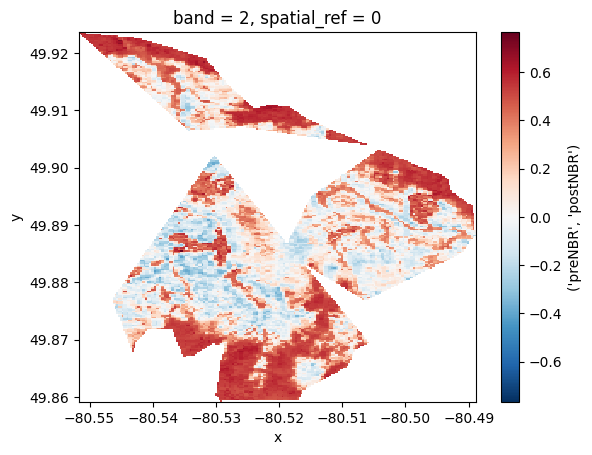

In [57]:
# check raster

fp2= "/Users/jgoldman/Google Drive/My Drive/chp3-sbw-fire/defol_cropped_pp/COC16_1997_1038.tif"
fp3= "/Users/jgoldman/Desktop/test_img.tif"
t = rx.open_rasterio(fp3, masked= True,)
t[1].squeeze().plot.imshow()
